==============================================================================================
# Practicum 5

==============================================================================================

## Delivery

Your overall grading will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented exhaustively and in **English**. 

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Answers to questions also need to be in **English**.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- The deliverable of both parts must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook (upload the ones that were not provided)
    
- It is required that your code can be run by us without need of any modification and without getting any errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please refrain from utilizing resources like ChatGPT to complete this lab assignment.


**Deadline: December 22th, 23:00 h**

==============================================================================================

This lab covers the following topics: 
* Gaussian filters
* Descriptors based on texture
* Distance between images and similarity search
* Face detection using:
    * Haar-like features
    * Adaboost
    * PCA



==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



### Imports

In [11]:
%matplotlib inline
# GENERAL ONES FOR IMAGE ANALYSIS
import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import time
from skimage.io import imread
from scipy.ndimage import convolve
### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images/filter_bank.png">


We import Leung-Malik filters as follows:

In [2]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()
# NOTE: If this does not work, go to appendix for function code

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


### Plotting all filters

Plot the created filters as images similar to the figure above.

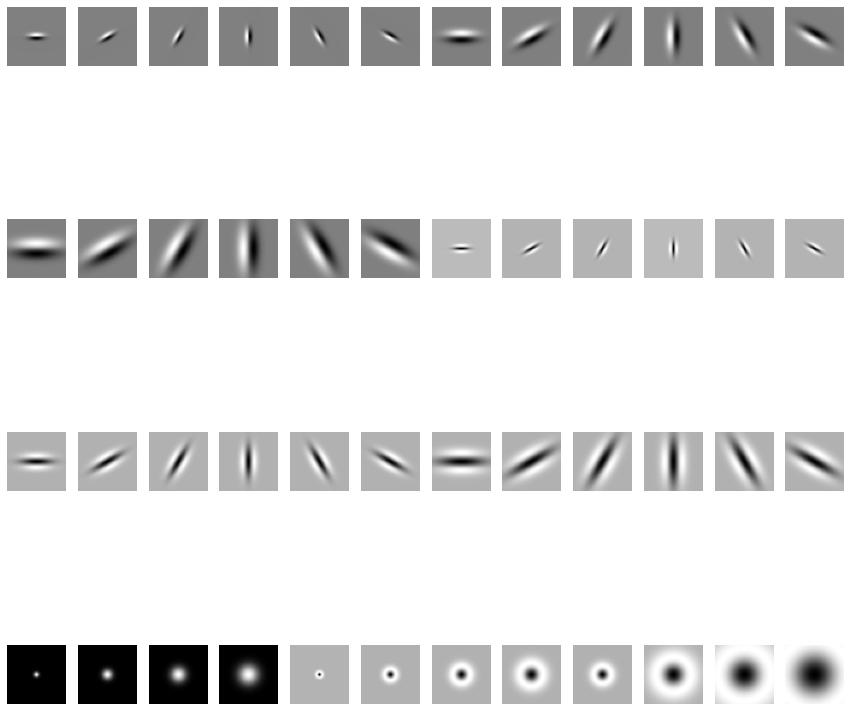

In [3]:
# Your solution here
f= (LM_filters.gaussian1d(2,2,1,1))
fig = plt.figure(figsize=(15, 15))

rows=4
cols=12


for i in range(48):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, cols, i+1)

    # showing image
    plt.imshow(filter_bank[:,:,i], cmap='gray')
    plt.axis('off')

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

In [5]:
# Your solution here
def resize_and_gray(img, new_shape=(240,240)):
    """
    Thsi function transform the image receive reescaling it to 240x240 then convert it to gray
    Args:
        img (numpy) :  numpy image with 3 dimensions
        new_shape (tuple) :  tuple of the new shape of the image Ex.(240,240)
    Returns: 
        numpy : numpy image with 2 dimensions
    """
    
    img = resize(img,new_shape)
    img= rgb2gray(img)
    return img  

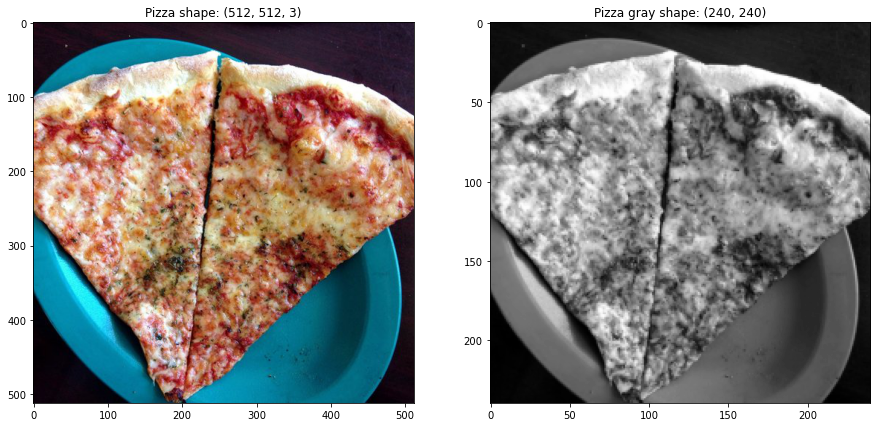

In [8]:
pizza_img = imread('./images/pizza.jpg')
pizza_gray = resize_and_gray(pizza_img,(240,240))

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.imshow(pizza_img)
plt.title('Pizza shape: '+str(pizza_img.shape))

fig.add_subplot(1, 2, 2)
plt.imshow(pizza_gray, cmap='gray')
plt.title('Pizza gray shape: '+str(pizza_gray.shape))
plt.show()


**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the **mean of the absolute value of the convolved image** by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [9]:
# Your solution here
%matplotlib inline

def get_image_features(image, filter_bank, n_filters):
    """
    This function will compare the image passed with the filter in the filter_bank and return a lsit with the mean value od each convultion of the image with one filter 
    Args:
        image (numpy) : numpy of and image RGBç
        filter_bank (list) : A list 3 dimensional with all the filters
        n_filters (int) : The number of filters we want to use and len of array to return
    Returns:
        numpy.ndarray : Featurte vector with the mean value of each filter used
    """
    
    image_gray = resize_and_gray(image, (240,240))
    mean_array_features = np.zeros(n_filters)

    for i in range(n_filters):
        filter_to_use = filter_bank[:,:,i]
        mean_array_features[i] = np.mean(np.abs(convolve(image_gray, filter_to_use)))

    return mean_array_features
    

In [12]:
## Try the function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
im_features

array([0.01601324, 0.01450963, 0.01425697, 0.01591414, 0.01726521])


**1.3** (Optional) Try ``get_image_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [13]:
# Your solution here
dog_img = imread('./images/dog.jpg')
flower_img = imread('./images/flower.jpg')

print("Dog features", get_image_features(dog_img, filter_bank, 5))
print("Flower features", get_image_features(flower_img, filter_bank, 5))

Dog features [0.00677731 0.00666375 0.00771554 0.00893743 0.00874988]
Flower features [0.01122807 0.01211678 0.01379493 0.01438382 0.01317932]


### Visualizing features

**1.4** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that receives the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [14]:
# Your solution here
def visualize_features(im,  filter_bank, n_filters=5):
    rows = 2
    cols = n_filters
    
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        # Create img convoluted
        result = np.abs(convolve(im, filter_bank[:,:,i]))
        fig.add_subplot(rows,cols , i+1)
        plt.imshow(result, cmap='gray')
        plt.axis("off")
        
        fig.add_subplot(rows - 1,cols , i+1)
        plt.imshow(filter_bank[:,:,i], cmap='gray')

        plt.axis("off")   

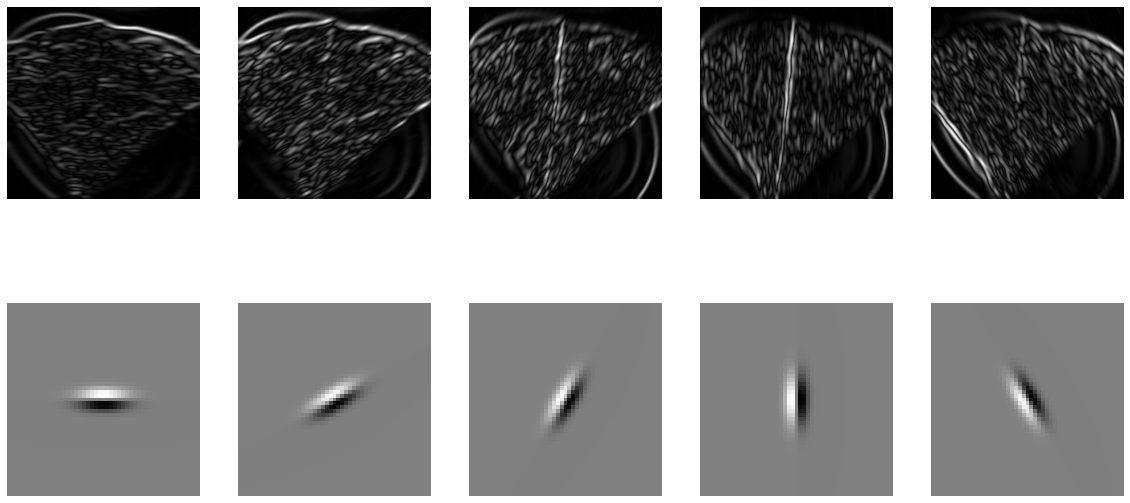

In [15]:
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.5** (Optional) Try ``visualize_features()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

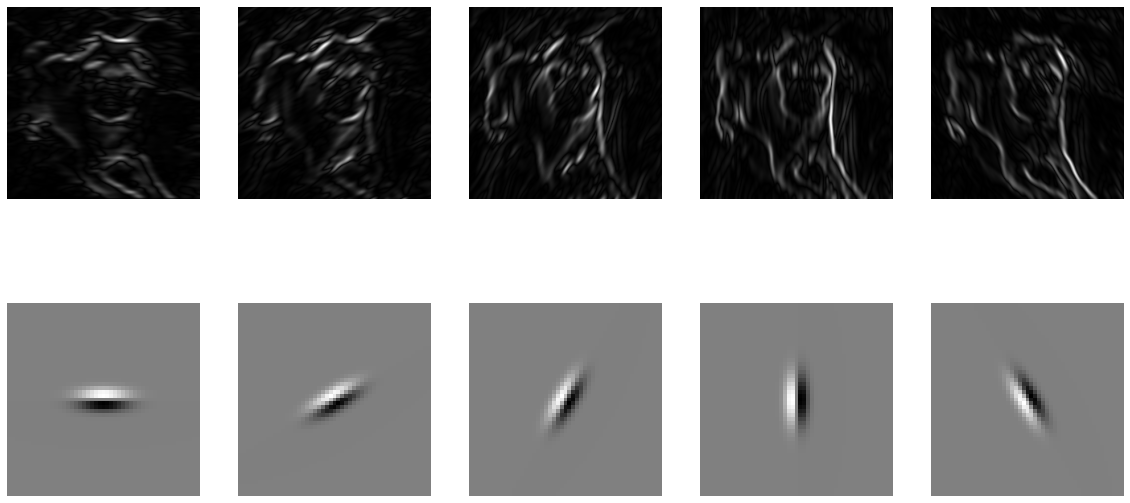

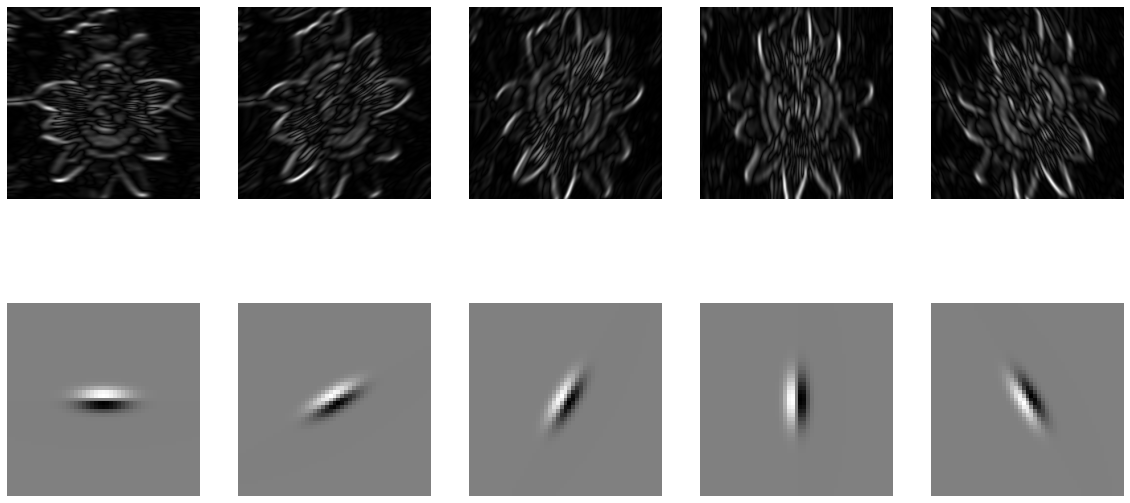

In [16]:
# Your solution here
dog_img = imread('./images/dog.jpg')
flower_img = imread('./images/flower.jpg')

dog_gray = resize_and_gray(dog_img)
flower_gray = resize_and_gray(flower_img)

visualize_features(dog_gray, filter_bank)
visualize_features(flower_gray, filter_bank)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [17]:
# Your solution here
def list_imgs_from_path(path):
    """
    This function will return a list with all the images in the path, the images will be numpy
    Args:
        path (str): Relative path from where this file is being executed
    Returns:
        numpy.ndarray : List of numpys where each numpy represente an image
    """
    if os.path.exists(path) == False:
        return None
    images = os.listdir(path)
    for i in images:
        if '.jpg' not in i:
            images.remove(i)
    all_images = [imread(path + img) for img in images]
    return all_images

def resize_list_of_images(img_list, new_shape=(240,240)):
    """
    This function will resize a list of images
    Args:
        img_list (list) : List of numpy images
        new_shape (tuple) : Tuple containing the new shape. Default is (240,240)
    Returns:
        list: List of resized images
    """
    resized_imgs = []
    for img in img_list:
        resized_imgs.append(resize(img, (new_shape)))
    return resized_imgs
# Get the images
pizza_images = list_imgs_from_path('./images/pizza/')
flowers_images = list_imgs_from_path('./images/flowers/')
pets_images = list_imgs_from_path('./images/pets/')

# Resized the images
pizza_images = resize_list_of_images(pizza_images)
flowers_images = resize_list_of_images(flowers_images)
pets_images = resize_list_of_images(pets_images)

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

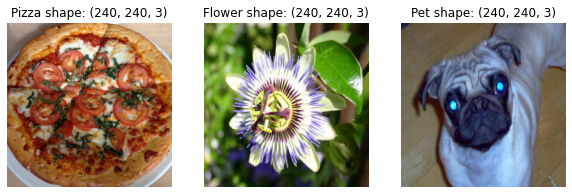

In [18]:
# Your solution here
fig = plt.figure(figsize=(10,4))

fig.add_subplot(1, 3, 1)
plt.title('Pizza shape: ' + str(pizza_images[0].shape))
plt.imshow(pizza_images[0])
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.title('Flower shape: ' + str(flowers_images[0].shape))
plt.imshow(flowers_images[0])
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.title('Pet shape: ' + str(pets_images[0].shape))
plt.imshow(pets_images[0])
plt.axis('off')

plt.show()

How many images there are in **each** directory?

In [19]:
# Your solution here
print("Number of images \n", "Pizzas: ", len(pizza_images), "\n" ,"Flores: ", len(flowers_images), "\n" "Pets: ", len(pets_images))

Number of images 
 Pizzas:  30 
 Flores:  29 
Pets:  29


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `get_image_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [23]:
# Your solution here

def get_dataset_features(all_images, filter_bank, n_filters=6):

    n_images = len(all_images)
    data = np.zeros((n_images,n_filters))
 

    # Compute the lm_feature_rgb 
    for i in range(0,n_images):
        data[i] = get_image_features(all_images[i], filter_bank,n_filters)


    return data

In [24]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images,  filter_bank, n_filters)

Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[2]*), image #33, and image #53, directly from the vector

In [25]:
# Your solution here
print("Shape of feature vectors:",feature_vectors.shape, "Len of all images", len(all_images), "num n_filters:", n_filters)
print("All images 3", feature_vectors[2].shape)

print("All images 33", feature_vectors[32].shape)
print("All images 53", feature_vectors[52].shape)

Shape of feature vectors: (88, 5) Len of all images 88 num n_filters: 5
All images 3 (5,)
All images 33 (5,)
All images 53 (5,)


### Visualizing the features of an image

**2.3** Define a function `visualize_features_imgs(im_index, feature_vector)` that given n different images, plots their features. Use different colors to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

<img src="./images/example_plot_features.jpg" >


In [28]:
# Your solution here
def visualize_features_imgs(im_index, feature_vector):
    plt.plot(feature_vector[im_index[0]], color='r')
    plt.plot(feature_vector[im_index[1]], color='g')
    plt.plot(feature_vector[im_index[2]], color='b')

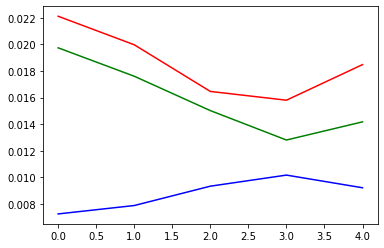

In [29]:
## Try the function
visualize_features_imgs( [2,32,52] , feature_vectors)


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [30]:
# Your solution here
def distance_ab(v1, v2):
    return np.around(np.linalg.norm(v1-v2),6)

def retrieve_images(im_features, feature_vectors, k=5):
    """
    This fuction will return the most similar vectors and the index where they are
    Args:
        im_features (numpy.ndarray) : An vector result of the functon get_images_features
        feature_vectors (numpy.ndarray) : A matrix with all the features of our bank of images (all_images)
        k (int) :  Number of iamges we want to retrieve
    Returns:
        tuple : A tuble where each position contains (a similar vector, index of the image), sorted by how similar they are
    """

    n_feature_vectors = len(feature_vectors)

    closest_images = []

    for i, feature in enumerate(feature_vectors):
        # Calculate the distance from our image to the feature_vectors
        distance = distance_ab( im_features,feature)
        # If the image_featujre is not the same in the feature_vectors we save it in a tuple with the index of our image and its distance
 
        closest_images.append((i,distance))
    
    # Sort the data by distance
    closest_images.sort(key = lambda x: x[1])


    # Return 2 vectors one with the indexes and other with the distances
    return list(zip(*closest_images[0:k])) 

def retrieve_images_excluding_self(im_features, feature_vectors, k=5):
    """
    This fuction will return the most similar vectors and the index where they are
    Args:
        im_features (numpy.ndarray) : An vector result of the functon get_images_features
        feature_vectors (numpy.ndarray) : A matrix with all the features of our bank of images (all_images)
        k (int) :  Number of iamges we want to retrieve
    Returns:
        tuple : A tuble where each position contains (a similar vector, index of the image), sorted by how similar they are
    """

    n_feature_vectors = len(feature_vectors)

    closest_images = []

    for i, feature in enumerate(feature_vectors):
        # Calculate the distance from our image to the feature_vectors
        distance = distance_ab(feature , im_features)
        # If the image_featujre is not the same in the feature_vectors we save it in a tuple with the index of our image and its distance
        if distance != 0.:
            closest_images.append((i,distance))
    
    # Sort the data by distance
    closest_images.sort(key = lambda x: x[1])


    # Return 2 vectors one with the indexes and other with the distances
    return list(zip(*closest_images[0:k])) 

Try your function using ``/images/pizza.jpg``.

In [31]:
# Try your function
distances, closest = retrieve_images(im_features, feature_vectors, k=5)
print(closest, distances)

(0.0, 0.002419, 0.002901, 0.003088, 0.003372) (5, 35, 87, 11, 86)


**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [92]:
# Your solution here
def show_closest_images(all_images, closest, distances):
    n_images = len(closest)
    rows = 1
    cols = n_images
    
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_images):

        fig.add_subplot(rows,cols , i+1)
        plt.imshow(all_images[int(closest[i])])
        plt.title("Distance:" + str(distances[i]))
        plt.axis("off")
    plt.show()

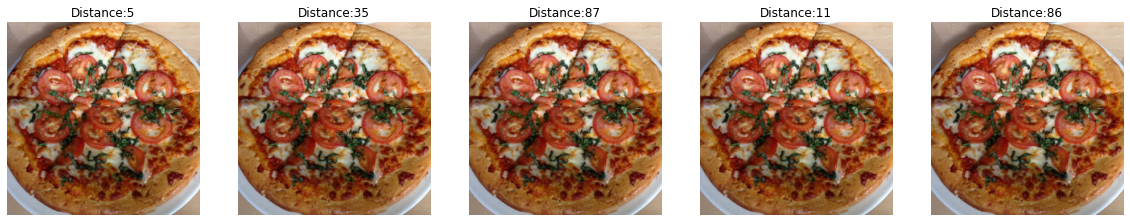

In [93]:
show_closest_images(all_images, closest, distances)

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [34]:
# Your solution here
def accuracy(feature_vectors, class_labels, im_features, class_im,  k=5):
    closest, distances = retrieve_images_excluding_self(im_features, feature_vectors, k)
    counter = 0
    for i in range(k):
        #class type of similar images
        img_type = class_labels[closest[i]] 

        if img_type == class_im:

            counter += 1
            
    # Calculate accurancy
    acc = counter/k
    return acc

In [36]:
"""
We create a array where the first we put the label to each image pizzas = 0 flowers = 1 pets=2
Pizzas:  30 
 Flores:  29 
Pets:  29
"""
class_labels = np.concatenate((np.zeros(30), np.ones(29),  2*np.ones(29))).reshape(88,1)
im_features =  get_image_features(pizza_img,filter_bank, n_filters)
total_img_retrieve = 5
class_of_image =0

In [37]:
print("acc:", accuracy(feature_vectors, class_labels, im_features, 0 , k=5))

acc: 0.2


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

In [38]:
total_img_retrieve = 10
print("acc:", accuracy(feature_vectors, class_labels, im_features, class_of_image ,total_img_retrieve))
print("Total imgs to retrieve:" ,total_img_retrieve, 'class_of_image ( pizzas = 0 flowers = 1 pets=2):', class_of_image)

acc: 0.2
Total imgs to retrieve: 10 class_of_image ( pizzas = 0 flowers = 1 pets=2): 0


### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

* Plot the new features of an image, using `visualize_features_imgs()`. 
* Then, show the 5 closest images (use show_closest_images) from `im_features`
* Compute the accuracy. 

**Is there any difference? Do we obtain the same images than previously?**

In [39]:
# Your solution here
maxi = 0
mini = 0
max_img = np.max(im_features)
min_img = np.min(im_features)

for i in range(feature_vectors.shape[0]):
    if np.max(feature_vectors[i]) > maxi : maxi =np.max(feature_vectors[i])
    if np.min(feature_vectors[i]) < mini : mini =np.min(feature_vectors[i])

normalize_feature_vectors =(feature_vectors - mini) / maxi-mini


new_im_features =(im_features-min_img) / max_img - min_img


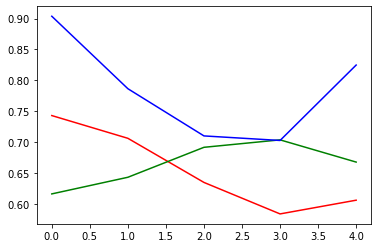

In [40]:
visualize_features( [0,11,21] , normalize_feature_vectors)

In [41]:
print("acc:", accuracy(normalize_feature_vectors, class_labels, new_im_features, class_of_image, k=5))

acc: 0.0


# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, similar to what it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** Consider each bin from each channel as a feature, create a vector with all the features together. 

In [42]:
# Your solution here
from skimage.exposure import histogram
from skimage import img_as_float

def lm_features_rgb(image, nbins=12):
    image = resize(image,(240,240))
    
     # Calculate the features for the image for every channel
    hist_r,r_bins = histogram(img_as_float(image[...,0]), nbins=nbins)  
    hist_g, g_bins= histogram(img_as_float(image[...,1]), nbins=nbins)
    hist_b, b_bins= histogram(img_as_float(image[...,2]), nbins=nbins)
    
    
    hist_r = np.reshape(hist_r,-1)
    hist_g = np.reshape(hist_g,-1)
    hist_b = np.reshape(hist_b,-1)

    # Concatenate

    hist_img = hist_r+ hist_g +hist_b
    hist_img = np.reshape(hist_img, -1)
    # Normalize the values

        
    return hist_img

In [44]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza_img)
print(len(lm_rgb_features))

12



## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in  `all_images` and save them in `lm_dataset_features`.

In [94]:
%%time 
'''
Solution
'''
import joblib
lm_dataset_features = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

Wall time: 3.58 s


## Compute the accuracy of the method using `lm_features_rgb`

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Show the 4 closest images to the query images in the `lm_rgb` space with the function built before.

Is the accuracy higher? Please, comment the results.

In [95]:
# Your solution here
print("acc:", accuracy(lm_dataset_features, class_labels, lm_features_rgb, 0, k=10))

TypeError: unsupported operand type(s) for -: 'int' and 'function'

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features.

### 6. Building integral image and Haar-like features

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="images/integral_image.PNG" width=250, height=2500>

An example :

<img src="images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

The use of an additional row and column full of zeros in the integral image is a common technique to simplify the computation of Haar features. This additional row and column are often referred to as the "border" or "padding." The main reasons for adding this border are simplifies computation, avoids special cases, consistent formulation and facilitates feature evaluation

**6.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one. Refrain from using built-in functions that already do the integral, compute it yourself. 

In [47]:
#your solution
def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    
    for x in range(1, img_arr.shape[0]+1): # For every row
        for y in range(1, img_arr.shape[1]+1): # For every column
            # Apply the formula
            integral_image_arr[x,y] = integral_image_arr[x-1,y] + integral_image_arr[x,y-1] - integral_image_arr[x-1,y-1] + img_arr[x-1,y-1]
    
    return integral_image_arr

In [48]:
# Visualizing results on a random grayscale image
random_img = np.random.rand(5,5)
integral_img = to_integral_image(random_img)

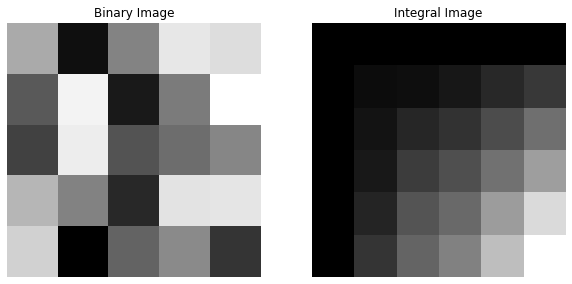

In [50]:
def show_bin_ii(binary, integral):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
    ax[0].imshow(binary, cmap = 'gray')
    ax[0].axis("off")
    ax[0].title.set_text("Binary Image")
    ax[1].imshow(integral, cmap = 'gray')
    ax[1].axis("off")
    ax[1].title.set_text("Integral Image")
    plt.show()

show_bin_ii(random_img,integral_img)

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [53]:
#your solution
def test(im, integral):
    # sum(img_array) doesn't work as intended. It doesn't compute the sum of all the elements
    # on the array, instead it returns an array of numbers that sometimes is the sum of rows
    # or columns, and sometimes it just doesn't make sense
    if im.sum() == integral[-1,-1]: 
        print("Test 1: Everything's running smoothly")
    else:
        print("Test 1: Something went wrong...")
    if im[0,:].sum() == integral[1,-1]:
        print("Test 2: Everything's running smoothly")
    else:
        print("Test 2: Something went wrong...")

test(random_img, integral_img)

Test 1: Everything's running smoothly
Test 2: Everything's running smoothly


**6.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

Here is an example (you don't have to pick this image, you can do it at random):
<img src="images/integral_image_example.jpg" width=500, height=250>

Test 1: Everything's running smoothly
Test 2: Everything's running smoothly


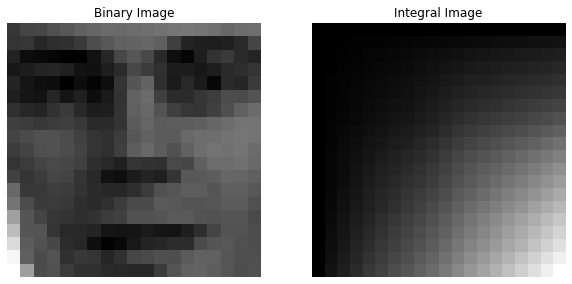

In [57]:
#your solution
face = io.imread("./images/faces/face00008.png") # Turn the face to grayscale
face = rgb2gray(face) if len(face.shape) ==3 else face
integral_face = to_integral_image(face) # Calculate the integral image

test(face, integral_face) # Test the integral function
show_bin_ii(face, integral_face) # Show the integral function and the face


**6.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage (no need to provide a written answer here, just make sure you are obtain same results).

Both functions have matching results


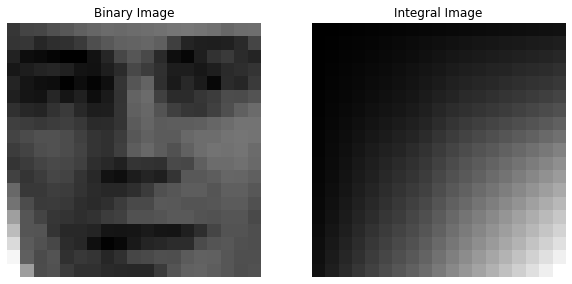

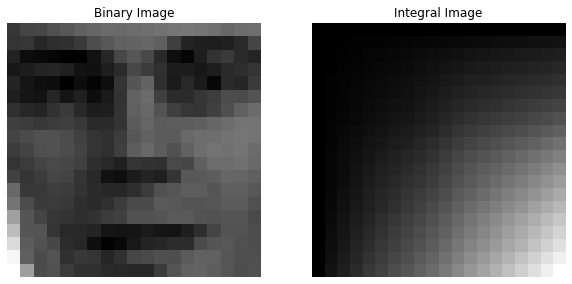

In [58]:
#your solution
ii_face = integral_image(face)
if ii_face[-1, -1] == integral_face[-1, -1]:
    print("Both functions have matching results")
show_bin_ii(face, ii_face)
show_bin_ii(face, integral_face)

## Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**6.4** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [61]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [62]:
#your solution
def extract_feature_image(image, feature_type, feature_coord=None):
    features = []
    # Create the integral of the image
    ii_im = integral_image(image)
    # Get the features
    features = skimage.feature.haar_like_feature(ii_im, 0, 0, ii_im.shape[0], ii_im.shape[1], feature_type=feature_type,feature_coord=feature_coord)
    return features


In [63]:
features = extract_feature_image(face, feature_types)
print(features.shape)

(63666,)


**6.5** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="images/image1.png" width=600, height=300>

*Note that there are multiple features and therefore your results might not exactly match this example, depending on your selection.*

In [64]:
#your solution
def plotFeatures(im, feature_types):
    fig = plt.figure(figsize=(5,8))
    c = 0
    fig.suptitle("The different Haar-like feature descriptors")
    for feature in feature_types:
        c+=1
        feat_coord, feat_type = haar_like_feature_coord(width=im.shape[1], height=im.shape[0], feature_type=feature)
        image = draw_haar_like_feature(im,0, 0, im.shape[0], im.shape[1],feat_coord, max_n_features=1, random_state=30)
        fig.add_subplot(3, 2, c)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(feature)

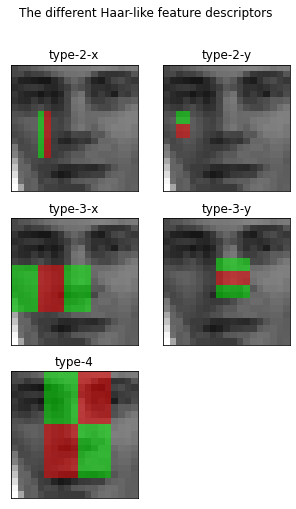

In [65]:
plotFeatures(face, feature_types)

## 7 Face detection using an Adaboost

**7.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features (use the `built extract_feature_image` for this). 

Futhermore, build the class labels vector ``y`` with the label of all the images. Make sure both, images and labels are numpy array objects.

In [68]:
from dask import delayed
# Your solution here
# Build a vector with the faces features
path = "./images/faces/"                       
face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

# Compute extract_feature_image for each face in the collection
features_faces = delayed(extract_feature_image(f, feature_types) for f in face_images).compute(scheduler='processes')



In [70]:
# Build a vector with the non-faces features
path = "./images/nonfaces/"                       
non_face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

# Compute extract_feature_image for each nonface in the collection
non_features_faces = delayed(extract_feature_image(f, feature_types) for f in non_face_images).compute(scheduler='processes')


In [71]:
X = np.array(features_faces + non_features_faces)
# Total faces = 39, total nonfaces = 29
y = np.array([1] * len(features_faces) + [0] * len(non_features_faces)) # Labels face = 1, non face = 0

**7.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Print the size of your images train and test set. 

In [72]:
# Your solution here
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0,stratify=y)

**7.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

AdaBoost is an adaptative classifier that takes simple classifiers and adapts them in sequence so that what the first didnt classify correctly, the second will.

In [73]:
# Your solution here
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

**7.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. Make sure to use your test set for this. What are these methods doing?

predict(): is taking an array of images' features and predicting whether each one is a face or not.

score(): is taking the predictions and comparing it to the actual real class of the images, then taking the correct answers divided by the total number of images

In [74]:
# Your solution here
predict = clf.predict(X_test)
print("The predictions of the classifier for the set X are:", predict)
acc = clf.score(X_test,y_test)
print("The accuracy of the classifier for the set X is:", acc)


The predictions of the classifier for the set X are: [0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0]
The accuracy of the classifier for the set X is: 0.9411764705882353


Change the parameter ``n_estimators`` and see what happens to the test set accuracy. Does the performance increased or decreased?

Try at least 3 different values of `n_estimators`

it decreased

In [75]:
# Your solution here
clf2 = AdaBoostClassifier(n_estimators=150, learning_rate=1.0, random_state=0)
clf2.fit(X_train, y_train)

predict = clf2.predict(X_test).tolist()
print("The predictions of the classifier for the set X are:", predict)
acc = clf2.score(X_test,y_test)
print("The accuracy of the classifier for the set X is:", acc)

The predictions of the classifier for the set X are: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
The accuracy of the classifier for the set X is: 0.8823529411764706


In [76]:
clf2 = AdaBoostClassifier(n_estimators=200, learning_rate=1.0, random_state=0)
clf2.fit(X_train, y_train)

predict = clf2.predict(X_test).tolist()
print("The predictions of the classifier for the set X are:", predict)
acc = clf2.score(X_test,y_test)
print("The accuracy of the classifier for the set X is:", acc)

The predictions of the classifier for the set X are: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
The accuracy of the classifier for the set X is: 0.8823529411764706


In [77]:
clf2 = AdaBoostClassifier(n_estimators=500, learning_rate=1.0, random_state=0)
clf2.fit(X_train, y_train)

predict = clf2.predict(X_test).tolist()
print("The predictions of the classifier for the set X are:", predict)
acc = clf2.score(X_test,y_test)
print("The accuracy of the classifier for the set X is:", acc)

The predictions of the classifier for the set X are: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
The accuracy of the classifier for the set X is: 0.8823529411764706


**7.5 (Optional)** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features of the model. 

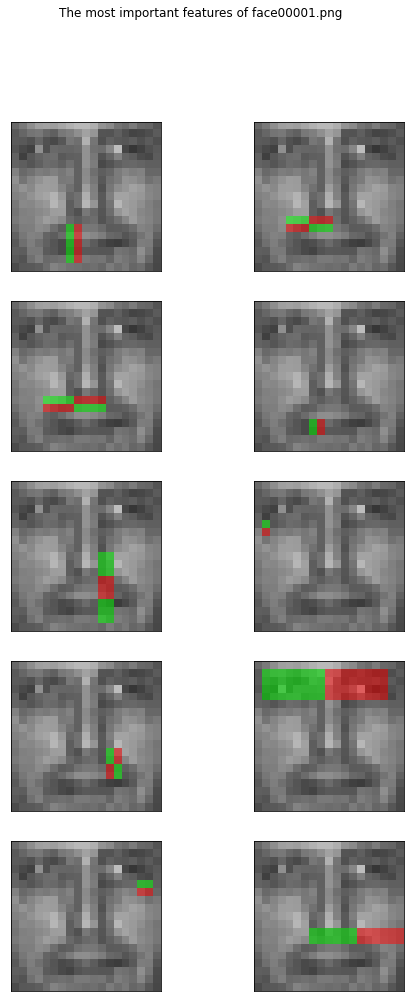

In [78]:
# Your solution here
# Sort the features
idx_sorted = np.argsort(clf.feature_importances_)[::-1]
# Change the face images to array
face_images = np.array(face_images)
# create the coordinates for the features
feature_coord, feature_type = haar_like_feature_coord(width=face_images.shape[2], height=face_images.shape[1], feature_type=feature_types)
# Create the subplots
fig, axes = plt.subplots(5, 2,figsize=(8,16))

for idx, ax in enumerate(axes.ravel()):
    # Take the image
    image = face_images[0]
    image = draw_haar_like_feature(image, 0, 0, face_images.shape[2], face_images.shape[1],[feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('The most important features of face00001.png')
plt.show()

==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 8. Load and prepare data for PCA

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**8.1** Load the dataset, obtaining only those cases where there are, **at least, 100 images**. Check the final number of images, image shapes and labels of the images.

*Hint: There is a parameter to set the minimum number of faces per person to load in the dataset function*

In [79]:
# Your solution here
from sklearn.datasets import fetch_lfw_people
# Load the data set of those cases that there are at least 100 images
dataset = fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=100, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)


**8.2** Plot an image frome each example, with its name as the title of the image.

<img src="images/example.png" width=500, height=500>

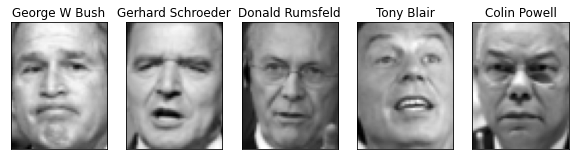

In [80]:
# Your solution here
remaining = set([x for x in range(max(dataset['target'])+1)])
imgs = []
c = 0
# While there's still examples to find
while remaining:
    target = dataset['target'][c]
    if target in remaining: # If the label is still in the remaining ones
        remaining.remove(target) # Remove it
        imgs.append((dataset['target_names'][target], dataset['data'][c])) # Append the img and the label
    c+=1
fig = plt.figure(figsize=(10,5))
c = 0
for im in imgs: # Plot the images
    c+=1
    fig.add_subplot(1, 5, c)
    plt.imshow(np.split(im[1], 62), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(im[0])

**8.3** Divide the dataset into train and test set (0.7/0.3). Print the size of train and test image sets.

Hint: use the train_test_split function.

In [81]:
# Your solution here
# Split dataset into training and test
from sklearn.model_selection import train_test_split 
# Split the dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.3, random_state=0)


## Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**8.4** Create a PCA object, using the training set and 150 components. 

*Consider that PCA requires the data to be reshaped into 2 dimensions: number of observations x number of pixels*

In [82]:
# Your solution here
# Principal component analysis
from sklearn.decomposition import PCA
# Create the PCA with 150 components
pca = PCA(n_components=150, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=0)
# Fit the model with train data
pca.fit(X_train, y_train)

PCA(n_components=150, random_state=0)

Plot the accumated variance of the components. 

**Hint:** Use `explained_variance_ratio_` to return the variance explained, plot this.

<img src="images/explained_variance_example.jpg" width=400, height=400>

In [83]:
# Your solution here
print("Each component gives us this percentages:", pca.explained_variance_ratio_)
print("The sum of all components variances shold be 1.0")

Each component gives us this percentages: [0.18115313 0.15672939 0.0698128  0.05805143 0.0516685  0.0309846
 0.02504707 0.02184116 0.01999607 0.01892561 0.01525514 0.01428884
 0.01325007 0.01057334 0.00998976 0.00939068 0.00913392 0.00876227
 0.0083523  0.00727167 0.00695574 0.00687772 0.00608581 0.00573356
 0.00542139 0.00540327 0.00492338 0.00472376 0.00459643 0.00444103
 0.00398167 0.00385805 0.00371804 0.00356844 0.00350724 0.0033767
 0.00332221 0.00316507 0.00311253 0.00299188 0.00290159 0.00286173
 0.00264728 0.00262181 0.00255624 0.0024964  0.00243677 0.00238636
 0.00223988 0.00217546 0.00210806 0.00205676 0.00200068 0.00197182
 0.00196031 0.00190543 0.00185974 0.00185089 0.00178541 0.00176743
 0.00172251 0.00169021 0.00168161 0.00161445 0.00158555 0.00157102
 0.00153519 0.00147186 0.00145417 0.00144007 0.00141618 0.00139448
 0.00135509 0.0013415  0.00133238 0.00129924 0.00125737 0.0012336
 0.00122285 0.00120845 0.00118231 0.00115337 0.00112706 0.00109212
 0.00108256 0.00105802 

**8.5** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly


<img src="images/mean_face.jpg" width=200, height=200>


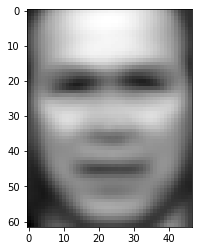

In [84]:
# Your solution here
plt.imshow(np.split(pca.mean_, 62), cmap = 'gray') # Show the mean face
plt.show()


**8.6** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

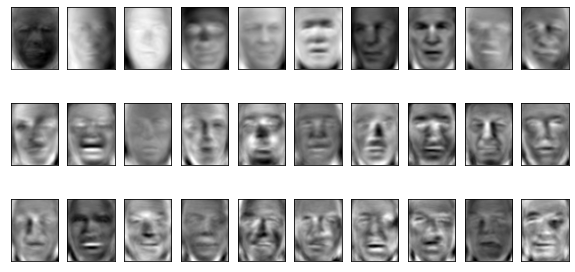

In [85]:
# Your solution here
fig = plt.figure(figsize=(10,5))
c = 0
for x in pca.components_[:30]: # For each of the first 30 components
    c+=1
    fig.add_subplot(3, 10, c)
    plt.imshow(np.split(x, 62), cmap = 'gray') # Split the feature vector into a 2D array (image)
    plt.xticks([])
    plt.yticks([])

**8.7** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="images/eigenfaces_image.PNG" width=300, height=300>

Example of output: 

<img src="images/recomposition_example.jpg" width=600, height=600>

In [86]:
# Your solution here
X_train_pca = pca.transform(X_train) # Transform the train set
X_test_pca = pca.transform(X_test) # Transform the test set


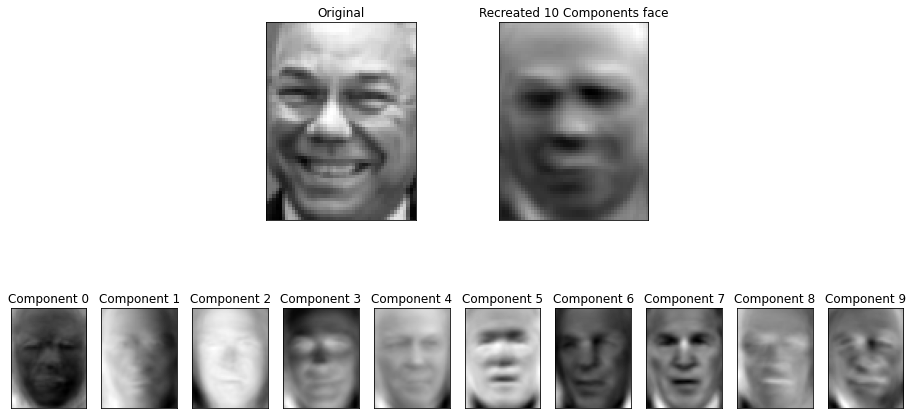

In [87]:
# Your solution here
result = np.zeros(62*47)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(2, 4, 2)
plt.imshow(np.split(X_test[0], 62), cmap='gray') # Show the original image
plt.xticks([])
plt.yticks([])
plt.title("Original")
for x in range(10): # For the first 10 components
    # Add the linear combination of this component
    result = result[:] + X_test_pca[0,x]*pca.components_[x] 
    fig.add_subplot(2, 10, 11+x)
    # Show the component vector splitted into a 2D array
    plt.imshow(np.split(pca.components_[x], 62), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Component " + str(x))
fig.add_subplot(2, 4, 3)
# Show the result
plt.imshow(np.split(result, 62), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Recreated 10 Components face")
plt.show()

## Train a classifier

**8.8** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [88]:
# Your solution here
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
# Create the Adaboost classifier
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)
%time clf.fit(X_train_pca, y_train) # Fit the train transformed set
%time clf.score(X_test_pca, y_test) # Score the transformed test set

Wall time: 693 ms
Wall time: 13 ms


0.5555555555555556

**8.9** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [89]:
# Your solution here
# Classification and results
from sklearn.metrics import classification_report 
y_pred = clf.predict(X_test_pca) # Predict the labels for the transformed test set
print(classification_report(y_test, y_pred, digits=2, zero_division='warn'))




              precision    recall  f1-score   support

           0       0.44      0.33      0.38        73
           1       0.81      0.40      0.54        42
           2       0.56      0.80      0.66       147
           3       0.50      0.24      0.33        37
           4       0.57      0.53      0.55        43

    accuracy                           0.56       342
   macro avg       0.58      0.46      0.49       342
weighted avg       0.56      0.56      0.53       342



## Recognize a new face example using the learned model

**8.10** Try your model using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="images/prediction.png" width=300 height = 300>

In [90]:
# Your solution here
def showimgs(imgs, pred, true):
    fig = plt.figure(figsize=(10,10))
    for x in range(12):
        fig.add_subplot(3, 4, x+1)
        plt.imshow(np.split(imgs[x], 62), cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.title("Predicted: " + dataset['target_names'][pred[x]] + "\nTrue: " + dataset['target_names'][true[x]])

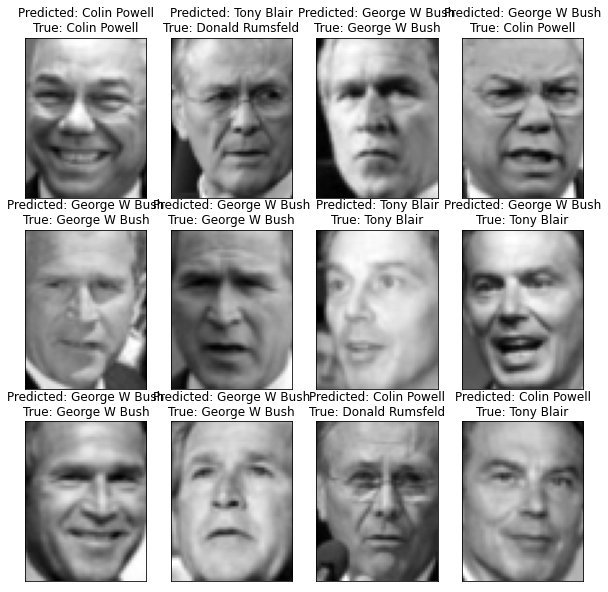

In [91]:
showimgs(X_test, clf.predict(X_test_pca), y_test)

# Appendix

In case the library for exercise 1 does not work for you, here is the function that will create the filters for you:

In [ ]:
"""
Functions needed to create the Leung-Malik (LM) filter bank
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F